In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from itertools import chain

In [2]:
load_dotenv("../.env")

True

In [3]:
from agent_system.src.tool_datasets import (
    ToolbenchDataset,
    APIGenDataset,
    MetaToolDataset,
    AnyToolbenchDataset,
    ToolbenchRetrievalDataset
)

/Users/woojeong/miniconda3/envs/agent/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset = "toolbench"
if dataset == "toolbench":
    ds = ToolbenchDataset()
    dir_name = "toolbench"
elif dataset == "toolbench_test":
    ds = ToolbenchRetrievalDataset(split="test")
    dir_name = "toolbench"
elif dataset == "apigen":
    ds = APIGenDataset()
    dir_name = "apigen"
elif dataset == "metatool":
    ds = MetaToolDataset()
    dir_name = "metatool"
elif dataset == "anytoolbench":
    ds = AnyToolbenchDataset()
    dir_name = "anytoolbench"

Loading from hf dataset: MerlynMind/toolbench_api
processing 'api_required_parameters' column
processing 'api_optional_parameters' column
Dataset Stats:
Number of queries: 40399
Number of APIs in total: 34191
Number of APIs with query: 8684
Number of total query-api pairs: 183034
Avg number of APIs per query: 4.530656699423253


# Generate bootstrap configs

In [5]:
unique_apis = sorted(ds.get_api_ids_with_query())
ds.get_query2apis(), len(unique_apis)
# qd_mapping = pd.concat([train_qd_mapping, test_qd_mapping])

({1: [18094, 18095],
  2: [18094, 18095],
  3: [18094, 18095],
  4: [18094, 18095],
  5: [18111, 18112, 18113, 18114, 18115, 18116, 18117, 18118, 18119, 18120],
  6: [18111, 18112, 18113, 18114, 18115, 18116, 18117, 18118, 18119, 18120],
  7: [18111, 18112, 18113, 18114, 18115, 18116, 18117, 18118, 18119, 18120],
  8: [18111, 18112, 18113, 18114, 18115, 18116, 18117, 18118, 18119, 18120],
  10: [18109, 18110],
  11: [18109, 18110],
  12: [18109, 18110],
  13: [18109, 18110],
  14: [18109, 18110],
  15: [18109, 18110],
  16: [18109, 18110],
  17: [18109, 18110],
  18: [18109, 18110],
  19: [18105, 18106, 18107, 18108],
  20: [18105, 18106, 18107, 18108],
  21: [18105, 18106, 18107, 18108],
  22: [18105, 18106, 18107, 18108],
  23: [18105, 18106, 18107, 18108],
  24: [18105, 18106, 18107, 18108],
  25: [18105, 18106, 18107, 18108],
  26: [18105, 18106, 18107, 18108],
  27: [18105, 18106, 18107, 18108],
  28: [18099, 18100, 18101, 18102],
  29: [18099, 18100, 18101, 18102],
  30: [18099, 

### Split by # of api groups

In [6]:
from agent_system.src.bootstrap import generate_split_info

# # of apis and how many times to repeat
n_api_list = [10, 50, 100, 200, 500, 1000, 2000] # 2000, 5000, len(unique_apis)]
n_repeat_list = [3] * len(n_api_list)  # [20, 20, 20, 20, 10, 10, 2, 1]
split_info_list = generate_split_info(ds, n_api_list, n_repeat_list)

[2024-08-23 19:28:00,221] {loader.py:97} INFO - Loading faiss.
[2024-08-23 19:28:00,271] {loader.py:99} INFO - Successfully loaded faiss.


Unique APIs: 8684
Unique API groups: 2613
# of apis: 10, # of trials: 3, mean # of queries 24.333333333333332
# of apis: 50, # of trials: 3, mean # of queries 182.0
# of apis: 100, # of trials: 3, mean # of queries 440.3333333333333
# of apis: 200, # of trials: 3, mean # of queries 868.6666666666666
# of apis: 500, # of trials: 3, mean # of queries 2312.3333333333335
# of apis: 1000, # of trials: 3, mean # of queries 4810.666666666667
# of apis: 2000, # of trials: 3, mean # of queries 9477.666666666666


# Load query/doc embeddings

In [7]:
embedding_dir = os.path.join(os.getenv("EMBEDDING_BASE_DIR"), f"api_embeddings_{dataset}")
summary_mode = 'raw'
embedding_mode = 'openai'
id2api_embed = pickle.load(open(os.path.join(embedding_dir, f'id2api_embed_{summary_mode}_{embedding_mode}.pkl'), 'rb'))
id2query_embed = pickle.load(open(os.path.join(embedding_dir, f'id2query_embed_{embedding_mode}.pkl'), 'rb'))

In [8]:
len(id2api_embed), len(id2query_embed)

(34191, 40399)

# Evaluate retrieval with varying # of apis

In [25]:
from agent_system.src.retrieval.utils import evaluate_retrieval

In [34]:
def bootstrap_retrieval(split_info):
    result_list = []
    for i in range(split_info['n_repeat']):
        print(f"Trial {i}/{split_info['n_repeat']}")
        current_split_info = {
            'n_apis': len(split_info['apis'][i]),
            'n_queries': len(split_info['queries'][i]),
            'apis': split_info['apis'][i],
            'queries': split_info['queries'][i]
        }
        _, results = evaluate_retrieval(ds.get_query2apis(), id2api_embed, id2query_embed, current_split_info["apis"], current_split_info["queries"], k_list=[5, 10])
        print(results)
        result_list.append({**current_split_info, **results})

    # print mean of results
    result_df = pd.DataFrame(result_list)
    return result_df

In [ ]:
bootstrap_results = []
for split_info in split_info_list:
    print(f"# of apis: {split_info['n_apis']}")
    result_df = bootstrap_retrieval(split_info)
    bootstrap_results.append(result_df)

# Aggregate results

In [36]:
bootstrap_results[0]

n_apis  n_queries                                               apis  \
0      10         19  [6560, 32106, 5073, 22674, 23987, 22675, 27638...   
1      10         20  [30993, 30994, 30995, 30996, 30997, 30998, 309...   
2      10         34  [19829, 19830, 19831, 19832, 19833, 19834, 198...   

                                             queries  MRR  Precision@5  \
0  [10504, 15030, 15031, 15032, 15033, 15035, 274...  1.0     0.315789   
1  [31870, 48874, 48875, 48876, 48878, 48881, 488...  1.0     1.000000   
2  [7675, 7676, 7677, 16379, 16380, 16381, 16383,...  1.0     1.000000   

   Recall@5  Precision@10  Recall@10  
0       1.0      0.157895        1.0  
1       1.0      1.000000        1.0  
2       1.0      1.000000        1.0

In [37]:
eval_results = []
select_columns = ["n_queries", "n_apis", "MRR", "Recall@5", "Recall@10"]
for df in bootstrap_results:
    eval_results.append(df[select_columns].mean().to_dict())

eval_df = pd.DataFrame(eval_results)
eval_df

n_queries  n_apis       MRR  Recall@5  Recall@10
0    24.333333    10.0  1.000000  1.000000   1.000000
1   182.000000    50.0  0.992820  0.995642   1.000000
2   440.333333   100.0  0.984771  0.990735   0.996037
3   868.666667   200.0  0.929689  0.971520   0.985562
4  2312.333333   500.0  0.905851  0.945460   0.964503
5  4810.666667  1000.0  0.873608  0.916856   0.943404
6  9477.666667  2000.0  0.851037  0.908651   0.939886

In [23]:
# save results
save_filename = f"retrieval_results/{dataset}_{summary_mode}_{embedding_mode}.csv"
print(save_filename)
eval_df.to_csv(save_filename, index=False)

retrieval_results/toolbench_train_raw_openai.csv


# Plot

In [27]:
x_axis = "n_apis"
y_axis = "Recall@10"

In [28]:
# (summary_mode, embedding_mode)
legends = [("raw", "openai"), ("raw", "toolbench-retriever")]
legends = [("raw", "openai"),]
plot_df = {}
for legend in legends:
    summary_mode, embedding_mode = legend
    column_name = f"{summary_mode}_{embedding_mode}"
    # load csv file
    save_filename = f"retrieval_results/{dataset}_{summary_mode}_{embedding_mode}.csv"
    eval_df = pd.read_csv(save_filename)
    # extract x and y values
    x_values = eval_df[x_axis].values
    y_values = eval_df[y_axis].values

    # save y values
    plot_df[column_name] = y_values

    # save x values if not exists
    if x_axis not in plot_df:
        plot_df[x_axis] = x_values
    else:
        print(plot_df[x_axis], x_values)
        # assert np.all(plot_df[x_axis] == x_values)

plot_df = pd.DataFrame(plot_df)
plot_df

raw_openai        n_apis
0    0.997917     47.640000
1    0.972891    472.360000
2    0.922971   2073.160000
3    0.897196   3616.000000
4    0.870201   5617.566667
5    0.833480  10337.000000

In [30]:
plot_df

raw_openai        n_apis
0    0.997917     47.640000
1    0.972891    472.360000
2    0.922971   2073.160000
3    0.897196   3616.000000
4    0.870201   5617.566667
5    0.833480  10337.000000

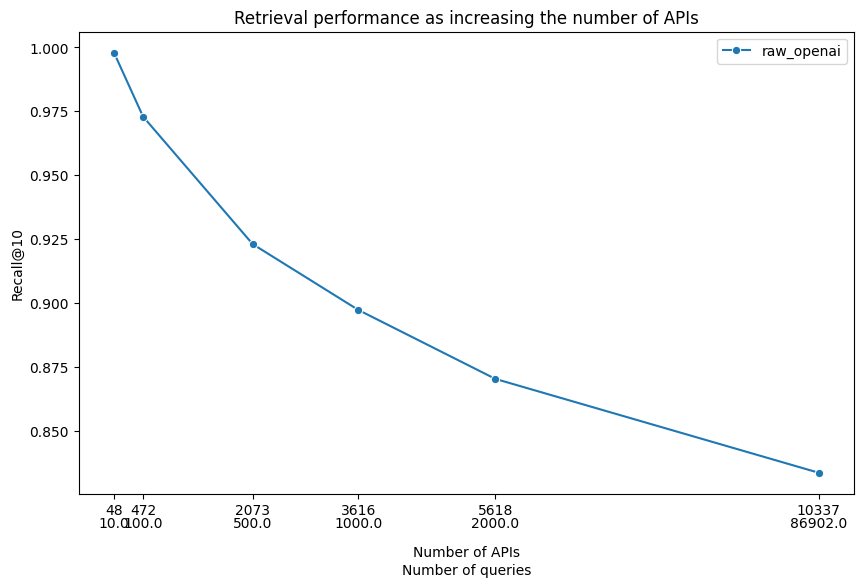

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# x_axis = "n_apis"
# summary_mode = "raw"
xticks = plot_df["n_apis"]

plt.figure(figsize=(10, 6))
for legend in legends:
    summary_mode, embedding_mode = legend
    column_name = f"{summary_mode}_{embedding_mode}"
    sns.lineplot(data=plot_df, x=x_axis, y=column_name, label=column_name, marker='o')

# Add title and labels
plt.title('Retrieval performance as increasing the number of APIs')
plt.xlabel("Number of APIs", labelpad=20)
plt.ylabel(y_axis)
plt.xticks(xticks)

# Add additional text below each xtick
additional_xticks = eval_df["n_queries"]
for i, text in enumerate(additional_xticks):
    plt.text(xticks[i], -0.05, text, ha='center', va='top', transform=plt.gca().get_xaxis_transform())

# add text next to x-ticks
text = "Number of queries"
plt.text(0.5, -0.15, text, ha='center', va='top', transform=plt.gca().transAxes)

# add legend
plt.legend()
plt.show()


# API clustering

In [29]:
for id, query in ds.id2query.items():
    print(query)
    print(ds.get_apis_by_query_id(id))
    print()

Please provide me with the users' data from Reqres. Additionally, I need the list of unknown resources and their details to understand the available resources.
[{'category_name': 'Data', 'tool_name': 'Reqres', 'tool_description': 'Reqres', 'tool_title': 'Reqres', 'tool_pricing': 'FREEMIUM', 'tool_home_url': 'https://rapidapi.com/alextrevgoda/api/reqres4/', 'tool_host': 'reqres4.p.rapidapi.com', 'tool_avg_service_level': 100.0, 'tool_avg_latency': 516.0, 'tool_avg_success_rate': 100.0, 'tool_popularity_score': 8.2, 'tool_name_standardized': nan, 'api_name': 'Users', 'api_url': 'https://reqres4.p.rapidapi.com/api/users', 'api_description': 'Users', 'api_method': 'GET', 'api_required_parameters': [], 'api_optional_parameters': [{'name': 'page', 'type': 'STRING', 'description': '', 'default': '2'}], 'api_code': 'import requests\n\nurl = "https://reqres4.p.rapidapi.com/api/users"\nquerystring = {"page": page}\n\nheaders = {\n    "X-RapidAPI-Key": "SIGN-UP-FOR-KEY",\n    "X-RapidAPI-Host": "

In [32]:
id2api_embed.values()

In [13]:
# cluster api embeddings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(list(id2api_embed.values()))

# get cluster labels
cluster_labels = kmeans.labels_
cluster_labels

array([ 8, 18, 10, ..., 24, 48, 31], dtype=int32)

In [33]:
# check first cluster
first_cluster_apis = (cluster_labels == 4).nonzero()[0]
print(f"cluster size: {first_cluster_apis}")
for api in first_cluster_apis:
    print(ds.api_data[api])

array([ 437,  444,  576,  748,  920,  922, 1652, 1736, 1737, 1745, 1827,
       1835, 1873, 1909, 1974, 2152, 2174, 2853, 2933, 2970, 3044, 3242,
       3264, 3331, 3344, 3381])

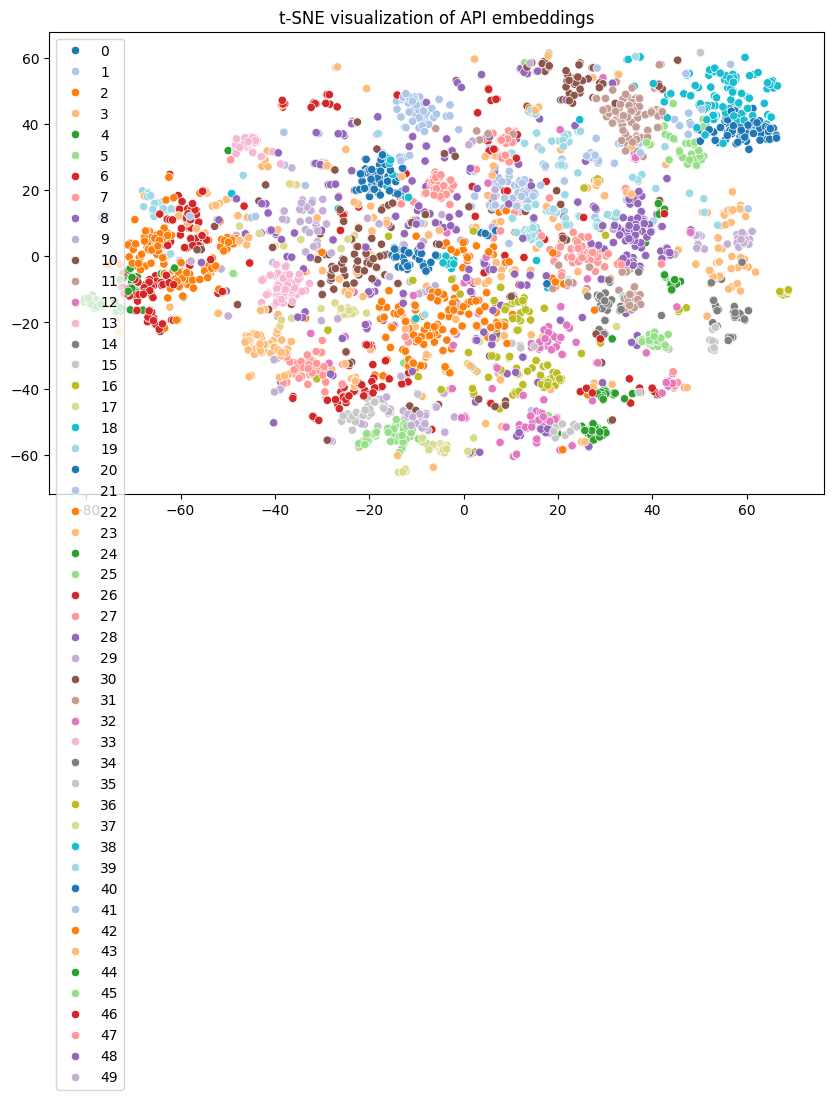

In [19]:
# tsne visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, random_state=0)
api_embeds = np.stack(list(id2api_embed.values()))
tsne_embeds = tsne.fit_transform(api_embeds)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_embeds[:, 0], y=tsne_embeds[:, 1], hue=cluster_labels, palette='tab20')
plt.title('t-SNE visualization of API embeddings')
plt.show()
